# Multiclass classification - Neural Network dataset(BOW)

# Importing and Preprocessing

## Importing libraries

In [1]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [4]:
original_data = pd.read_pickle("../../dataset/final_dataset/nn_final.pkl")

## Preprocessing

In [7]:
df = original_data.copy()

#converting to lower case
# df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
# df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
# df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
# df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df

,question,student_answer,grades_round,student_modified
0,"Give a definition for the term ""artificial ne...",An artificial neural network is a massively pa...,2,artificial neural network massively parallel d...
1,"Give a definition for the term ""artificial ne...",Artificial neural network consists of: . Large...,2,artificial neural network consists largely par...
2,"Give a definition for the term ""artificial ne...",An artificial neural network is a massive dist...,1,artificial neural network massive distributed ...
3,"Give a definition for the term ""artificial ne...",An ANN is a layered graphical model containing...,2,ann layered graphical model containing neuron ...
4,"Give a definition for the term ""artificial ne...",Artificial Neural Networks are large parallel ...,2,artificial neural network large parallel proce...
5,"Give a definition for the term ""artificial ne...",An articial neural network consists of neurons...,1,articial neural network consists neuron neuron...
6,"Give a definition for the term ""artificial ne...",An ANN is a - massivly parallel distibuted Pro...,2,ann massivly parallel distibuted processor mad...
7,"Give a definition for the term ""artificial ne...",A ANN is a massively distributed processor. It...,2,ann massively distributed processor propensity...
8,"Give a definition for the term ""artificial ne...",An artificial neural network is defined as a l...,2,artificial neural network defined learning mac...
9,"Give a definition for the term ""artificial ne...",An artificial neural network is a graph of sma...,2,artificial neural network graph small identica...


# Gathering required features

In [6]:
short_df = df[['question','student_answer','student_modified','grade']]
# short_df['grades_round']= short_df['grade'].apply(lambda x: round(x))
short_df

KeyError: "['grade'] not in index"

# Bag of words

In [5]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['grade'].values

# Seeding

In [6]:
#getting the seed index
classes = short_df['grade'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['grade'][short_df['grade']==i].index[0])
seed_index

[0, 2, 88]

# Logistic Regression

In [10]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
lr = LogisticRegression()
# nb = MultinomialNB()
learner = ActiveLearner(
    estimator = lr,
#     estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X_pool, y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.292868
Accuracy after query no. 2: 0.399696
Accuracy after query no. 3: 0.401826
Accuracy after query no. 4: 0.463415
Accuracy after query no. 5: 0.404580
Accuracy after query no. 6: 0.415902
Accuracy after query no. 7: 0.399694
Accuracy after query no. 8: 0.411043
Accuracy after query no. 9: 0.447005
Accuracy after query no. 10: 0.420000
Accuracy after query no. 11: 0.389831
Accuracy after query no. 12: 0.447531
Accuracy after query no. 13: 0.451314
Accuracy after query no. 14: 0.442724
Accuracy after query no. 15: 0.458915
Accuracy after query no. 16: 0.475155
Accuracy after query no. 17: 0.493002
Accuracy after query no. 18: 0.484424
Accuracy after query no. 19: 0.499220
Accuracy after query no. 20: 0.482812
Accuracy after query no. 21: 0.527387
Accuracy after query no. 22: 0.551724
Accuracy after query no. 23: 0.576138
Accuracy after query no. 24: 0.562893
Accuracy after query no. 25: 0.562205
Accuracy after query no. 26: 0.563091
Accuracy after query 

# Multinomial Naive Bayes 

In [12]:
act_data = short_df.copy()
accuracy_list_nb = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
# nb = MultinomialNB()
nb = SVC(kernel='linear' , probability=True)
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list_nb.append(learner.score(X_pool, y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.355083
Accuracy after query no. 2: 0.361702
Accuracy after query no. 3: 0.374429
Accuracy after query no. 4: 0.388720
Accuracy after query no. 5: 0.383206
Accuracy after query no. 6: 0.385321
Accuracy after query no. 7: 0.382848
Accuracy after query no. 8: 0.383436
Accuracy after query no. 9: 0.380952
Accuracy after query no. 10: 0.384615
Accuracy after query no. 11: 0.386749
Accuracy after query no. 12: 0.379630
Accuracy after query no. 13: 0.395672
Accuracy after query no. 14: 0.421053
Accuracy after query no. 15: 0.480620
Accuracy after query no. 16: 0.492236
Accuracy after query no. 17: 0.531882
Accuracy after query no. 18: 0.537383
Accuracy after query no. 19: 0.535101
Accuracy after query no. 20: 0.534375
Accuracy after query no. 21: 0.544601
Accuracy after query no. 22: 0.543887
Accuracy after query no. 23: 0.497645
Accuracy after query no. 24: 0.498428
Accuracy after query no. 25: 0.379528
Accuracy after query no. 26: 0.411672
Accuracy after query 

## Regular supervised task

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)
lr = LogisticRegression()
lr.fit(X_train, Y_train)
score_lr = lr.score(X_test, Y_test)
score_lr

0.6616541353383458

In [11]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)
nb = MultinomialNB()
nb.fit(X_train, Y_train)
score_nb = nb.score(X_test, Y_test)
score_nb

0.6090225563909775

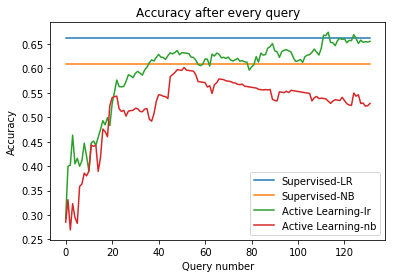

In [12]:
supervised_accuracy_lr = [score_lr for x in range(0,n_queries)]
supervised_accuracy_nb = [score_nb for x in range(0,n_queries)]


plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy_lr)
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy_nb)
plt.plot(accuracy_list)
plt.plot(accuracy_list_nb)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised-LR", "Supervised-NB","Active Learning-lr","Active Learning-nb"], loc="lower right")
plt.show()

In [13]:
#checking the baseline
len(df[df['grade'] == 2]) / len(df)


0.5158371040723982